# Machine Learning in Scikit-learn

If you are a self-guided learner:      
https://scikit-learn.org/stable/auto_examples/index.html   
Scikit-learn documentation has a variety of examples covering the broad scope of ML

# But first, a reminder about Pandas Datareader and FRED
### State Level Data
https://fred.stlouisfed.org/categories/27281 

Find the code in the Suggested Citation and the Tital of each data page
e.g. on the page for Total Gross Domestic Product for Alabama   

Suggested Citation:
U.S. Bureau of Economic Analysis, Total Gross Domestic Product for Alabama [ALNGSP], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/ALNGSP, November 20, 2020.

    
For more on Pandas Datareader and FRED   
https://medium.com/swlh/pandas-datareader-federal-reserve-economic-data-fred-a360c5795013 

In [129]:
import pandas_datareader.data as web
import datetime

start = datetime.date(year=2014, month=1,  day=1)
end   = datetime.date(year=2019, month=12, day=31)
series = ['ALNGSP','MEHOINUSALA672N']
source = 'fred'
df = web.DataReader(series, source, start, end)
df.reset_index(inplace = True)
df.head()


# ALNGSP total GDP AL
# MEHOINUSALA672N real median household income

,DATE,ALNGSP,MEHOINUSALA672N
0,2014-01-01,195037.7,45701
1,2015-01-01,200197.5,48030
2,2016-01-01,204454.7,50308
3,2017-01-01,210895.7,53049
4,2018-01-01,221030.7,50841


## A Quick Note on ML & Algorithmic Bias
#### From Merritt
Machine learning, like most of the topics you’re learning this quarter, is a very deep discipline that we’re only going to touch the surface of. Unlike most other disciplines you’re learning this quarter, you can do quite a bit of damage if you apply machine learning incorrectly. It is of the utmost importance to apply machine learning carefully and always with an eye towards fairness, accountability, and explainability.
Algorithms themselves are not biased, but they can return results that are biased against certain groups of people if the data fed into them is biased. The data is almost guaranteed to be biased if you are using data from the real world, because the real world is biased against certain groups of people. For example, the National Institute of Standards and Technology recently found that facial recognition algorithms are 10 to 100 times more likely to inaccurately identify an East Asian or black face compared to a white face (<a href=“https://www.scientificamerican.com/article/how-nist-tested-facial-recognition-algorithms-for-racial-bias”>Scientific American</a>).
This is even more of a problem when algorithms determine important decisions, like whether an individual is <a href=“https://www.law.upenn.edu/live/files/7952-kearns-finalpdf”>eligible for a loan</a>, or <a href=“https://www.businessinsider.com/amazon-ai-biased-against-women-no-surprise-sandra-wachter-2018-10”>whether to invite an individual for a job interview</a>. There is a developing literature on this topic, known as FATML (Fairness, Accountability, and Transparency in Machine Learning). There are no one size fits all solutions, but there are some basic steps you can take, like evaluating the outcomes based on all types of groupings of individuals, using tools like <a href=“https://github.com/dssg/aequitas”>aequitas</a> (developed by some Harris folks among others), and generally being sensitive and attentive to the potential biases your algorithm might propagate.     

# Supervised Machine Learning Example
### Predict Average Annual Death by CVD Quartiles in Chicago Community Areas

__Steps__

1. Choose a model by importing its class from Scikit-Learn
2. Choose (non-data) parameters by creating an instance of the above class
3. Arrange data into the labels matrix and features matrix
4. Fit the data to the instance of the model
5. Examine results (e.g. predict, plot)

In [86]:
import os
import pandas as pd
import requests
import seaborn as sns

In [131]:
path = '/Users/Sarah/Documents/GitHub/Sarah-Discussion-Notebooks/Data'

base_url = 'https://data.cityofchicago.org/api/views/{}/rows.csv?accessType=DOWNLOAD'
file_name = [('kn9c-c2s2', 'Chicago_SES.csv'),
            ('j6cj-r444','Chicago_Death.csv')]


def download_data(url, filename):
    if filename not in os.listdir(path):
        response = requests.get(url)
        output = response.text
        with open(filename, 'w') as ofile:
            ofile.write(output)

def read_data(path, filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(path, filename))
    elif filename.endswith('.xls'):
        df = pd.read_excel(os.path.join(path, filename))
    else:
        return 'unexpected file type in read_data'
    return df

def build_urls(base_url, num):
    return base_url.format(num)    
    
        
def parse_death(death_df):
    death_df.rename(columns = {'Community Area': 'Community Area Number'}, inplace=True)
    avg_an_death = death_df.pivot(index = 'Community Area Number', columns='Cause of Death', 
                                  values='Average Adjusted Rate 2006 - 2010')
    avg_an_death.drop(0, axis = 0, inplace = True) #drop the Chicago Total
    avg_an_death.reset_index(inplace = True)
    # create a colomn for Quartile of Avearge Annual Deaths by Coronary Heart Disease
    avg_an_death['CVD_quartile'] = (pd.qcut(avg_an_death['Coronary heart disease'], 
                                            4, labels=['Q1', 'Q2', 'Q3', 'Q4']))
    # cite: https://stackoverflow.com/questions/62610541/calculated-quartile-category-of-a-column-in-pandas
    
    # drop total dealths
    avg_an_death.drop(columns = ['All Causes', 'Coronary heart disease'], inplace = True)
    return avg_an_death


def merge_dfs(SES_df, death_df):     
    SES_death = SES_df.merge(death_df, on='Community Area Number', how = 'inner')
    
    #drop colums with Nan (all cols dropped for this df are completely empty)
    SES_death.dropna(axis=1,inplace=True)

    return SES_death


def prep_df(base_url, file_name):
    urls = [] 
    for n, f in file_name:
        urls.append((build_urls(base_url, n), f)) 
 
    # download if not present andread in df
    df_contents = []
    for url, filename in urls:
        download_data(url,filename)
        df = read_data(path, filename)
        if filename == 'Chicago_Death.csv':
                df_contents.append(parse_death(df))
        else:
            df_contents.append(df)

    merged = merge_dfs(df_contents[0], df_contents[1])
    
    return merged

use_df = prep_df(base_url, file_name)

In [132]:
use_df.columns

Index(['Community Area Number', 'COMMUNITY AREA NAME',
       'PERCENT OF HOUSING CROWDED', 'PERCENT HOUSEHOLDS BELOW POVERTY',
       'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX', 'All causes in females', 'All causes in males',
       'Alzheimers disease', 'Assault (homicide)', 'Breast cancer in females',
       'Cancer (all sites)', 'Colorectal cancer', 'Diabetes-related',
       'Firearm-related', 'Injury, unintentional',
       'Kidney disease (nephritis, nephrotic syndrome and nephrosis)',
       'Liver disease and cirrhosis', 'Lung cancer',
       'Prostate cancer in males', 'Stroke (cerebrovascular disease)',
       'Suicide (intentional self-harm)', 'CVD_quartile'],
      dtype='object')

__Steps__

1. Choose a model by importing its class from Scikit-Learn
2. Choose (non-data) parameters by creating an instance of the above class
3. Arrange data into the labels matrix and features matrix
4. Fit the data to the instance of the model
5. Examine results (e.g. predict, plot)

In [133]:
# 3. Arrange data into the labels matrix and features matrix

X = use_df.drop(columns = ['CVD_quartile', 'COMMUNITY AREA NAME'])
Y = use_df['CVD_quartile']

In [134]:
# 3.5 divide data into 2:
# train (to "teach" your model) and
# test (to see how good your model is at predicting)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=123)

In [135]:
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(61, 24)
(61,)
(16, 24)
(16,)


In [136]:
X_train.head()

,Community Area Number,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,All causes in females,All causes in males,...,Colorectal cancer,Diabetes-related,Firearm-related,"Injury, unintentional","Kidney disease (nephritis, nephrotic syndrome and nephrosis)",Liver disease and cirrhosis,Lung cancer,Prostate cancer in males,Stroke (cerebrovascular disease),Suicide (intentional self-harm)
71,72.0,0.9,5.1,8.0,3.7,40.5,39523,12.0,689.1,792.9,...,19.7,19.8,5.7,18.4,14.2,5.3,44.1,44.0,49.7,7.4
43,44.0,3.3,27.8,24.0,14.5,40.3,18881,60.0,740.8,1229.5,...,20.7,37.7,36.3,35.3,30.1,5.9,51.1,54.3,42.1,7.6
51,52.0,6.8,19.2,12.1,31.9,42.8,17104,64.0,639.2,997.8,...,15.2,35.1,9.6,37.0,25.2,16.2,42.2,26.3,32.3,5.6
1,2.0,7.8,17.2,8.8,20.8,38.5,23040,46.0,570.2,843.0,...,17.1,24.5,3.9,21.1,21.0,7.7,37.8,16.9,34.3,6.1
37,38.0,3.3,29.3,24.3,15.9,39.5,23472,57.0,775.6,1356.0,...,25.7,31.6,26.3,42.9,21.3,12.2,65.7,35.9,49.0,6.0


In [137]:
Y_train.head()

71    Q2
43    Q2
51    Q1
1     Q2
37    Q3
Name: CVD_quartile, dtype: category
Categories (4, object): ['Q1' < 'Q2' < 'Q3' < 'Q4']

In [138]:
# 1. Choose a model by importing its class from Scikit-Learn
from sklearn.naive_bayes import GaussianNB

In [139]:
# 2. Choose (non-data) parameters by creating an instance of the above class
model = GaussianNB()

# 4. Fit the data to the instance of the model
model.fit(X_train, Y_train)
predict = model.predict(X_test)

In [140]:
# 5. Examine results (e.g. predict, plot)
predict

array(['Q4', 'Q1', 'Q4', 'Q1', 'Q3', 'Q1', 'Q1', 'Q1', 'Q1', 'Q2', 'Q1',
       'Q1', 'Q3', 'Q4', 'Q1', 'Q3'], dtype='<U2')

In [141]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [142]:
accuracy_score(Y_test, predict)

0.3125

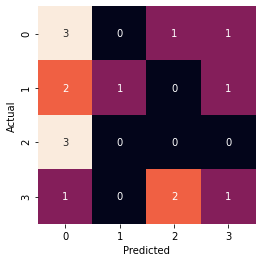

In [143]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(Y_test, predict)

ax = sns.heatmap(mat, square=True, annot=True, cbar=False)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

In [144]:
print(classification_report(Y_test, predict))

              precision    recall  f1-score   support

          Q1       0.33      0.60      0.43         5
          Q2       1.00      0.25      0.40         4
          Q3       0.00      0.00      0.00         3
          Q4       0.33      0.25      0.29         4

    accuracy                           0.31        16
   macro avg       0.42      0.28      0.28        16
weighted avg       0.44      0.31      0.31        16



In [145]:
model =  DecisionTreeClassifier()
model.fit(X_train, Y_train)
predict = model.predict(X_test)

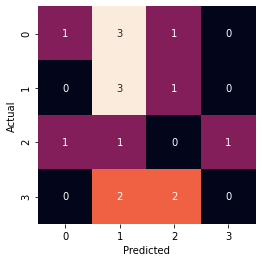

In [146]:
mat = confusion_matrix(Y_test, predict)

ax = sns.heatmap(mat, square=True, annot=True, cbar=False)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual');

In [147]:
print(classification_report(Y_test, predict))

              precision    recall  f1-score   support

          Q1       0.50      0.20      0.29         5
          Q2       0.33      0.75      0.46         4
          Q3       0.00      0.00      0.00         3
          Q4       0.00      0.00      0.00         4

    accuracy                           0.25        16
   macro avg       0.21      0.24      0.19        16
weighted avg       0.24      0.25      0.20        16



In [148]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [149]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

# create instances of the models
models = [('Dec Tree', DecisionTreeClassifier()), 
          ('Lin Disc', LinearDiscriminantAnalysis()), 
          ('Gauss', GaussianNB()), 
          ('SVC', SVC(gamma='auto')),
          ('KNN', KNeighborsClassifier(n_neighbors=3))]

In [150]:
# What is cross validation? 
# see here: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

results = []

for name, model in models:
    kf = StratifiedKFold(n_splits=10, random_state=123)
    res = cross_val_score(model, X_train, Y_train, cv=kf, scoring='accuracy')
    res_mean = round(res.mean(), 4)
    res_std  = round(res.std(), 4)
    results.append((name, res_mean, res_std))

/Users/Sarah/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/Sarah/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/Sarah/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/Sarah/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state ha

In [151]:
results #model, mean accuracy, std of accuracy

[('Dec Tree', 0.481, 0.2202),
 ('Lin Disc', 0.4286, 0.1887),
 ('Gauss', 0.4095, 0.1844),
 ('SVC', 0.1786, 0.0357),
 ('KNN', 0.3143, 0.1596)]

## Unsupervised

In [152]:
from sklearn.decomposition import PCA

model = PCA(n_components=2)

model.fit(X)

X_2D = model.transform(X)

In [153]:
use_df['PCA1'] = X_2D[:,0]
use_df['PCA2'] = X_2D[:,1]

/Users/Sarah/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


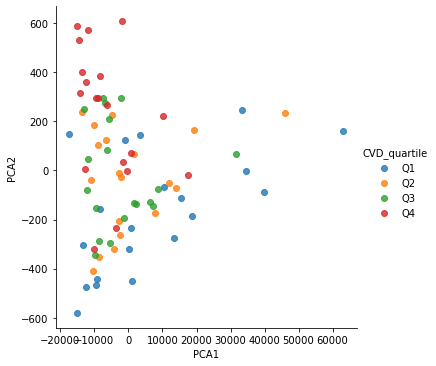

In [154]:
sns.lmplot('PCA1', 'PCA2', hue='CVD_quartile', data=use_df, fit_reg=False);